# Loading Data

## Imports

In [1]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Flatten, LeakyReLU, ReLU, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, concatenate, Activation
# from tensorflow.keras.utils import plot_model
# from tensorflow.keras.backend import clear_session
# from tensorflow.keras.optimizers import Adam, RMSprop , SGD
from tensorflow.keras import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
# from tensorflow.keras.regularizers import L2
# from tensorflow.keras import metrics
from tensorflow.keras import layers
from tensorflow import keras
import keras_tuner as kt
from keras import backend as K

import tensorflow as tf

from os.path import join
from os import listdir
from shutil import copy

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import cv2

## Creating data loaders

In [2]:
train_df = pd.read_csv("df//train_df_raw.csv")
val_df = pd.read_csv("df//val_df_raw.csv")
train_df.head()

,path,pH
0,preprocessingData\6\6K--22-_png.rf.663142c8817...,6
1,preprocessingData\6\6k--75-_png.rf.42aa0454726...,6
2,preprocessingData\6\6F--23-_png.rf.338da0e01de...,6
3,preprocessingData\6\6F--44-_png.rf.1521f3dad55...,6
4,preprocessingData\6\6k--13-_png.rf.47db8c03884...,6


In [3]:
# print(len(listdir("jpgData//6")))
# print(len(listdir("jpgData//7")))
# print(len(listdir("jpgData//8")))
# print(len(listdir("jpgData//9")))

In [4]:
x_col = "path"
y_col = "pH"
batch_size = 16
epochs = 1024
lr = 1e-5
image_size = (128,128)
channels = 3
shuffle = True
class_mode ="raw"
color_mode = "rgb"

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                     width_shift_range = 0.2,
                                     height_shift_range = 0.2, 
                                     zoom_range = 0.2,
                                     shear_range = 0.2,
                                     horizontal_flip = True,
                                     vertical_flip = True,
                                    #  channel_shift_range = 64.0,
                                     brightness_range = (0.5,1.0),
                                     rotation_range = 45,
                                     )
train_generator = train_datagen.flow_from_dataframe(dataframe=train_df,
                                              x_col=x_col, y_col=y_col, has_ext=True, 
                                              class_mode=class_mode, target_size=image_size, 
                                              batch_size=batch_size, color_mode = color_mode,
                                              shuffle = shuffle)
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_dataframe(dataframe=val_df,
                                              x_col=x_col, y_col=y_col, has_ext=True, 
                                              class_mode=class_mode, target_size=image_size, 
                                              batch_size=batch_size,  color_mode = color_mode,
                                              shuffle = shuffle)


Found 512 validated image filenames.
Found 132 validated image filenames.


# Design Alternatives

## Design A: Nested U-Net

In [186]:
# Defining the Convolutional Block
def conv_block(inputs, num_filters):
	# Applying the sequence of Convolutional, Batch Normalization
	# and Activation Layers to the input tensor
	x = Sequential([
		# Convolutional Layer
		Conv2D(num_filters, 1, padding='same'),
		# Batch Normalization Layer
		BatchNormalization(),
		# Activation Layer
		ReLU(),
		# Convolutional Layer
		Conv2D(num_filters, 1, padding='same'),
		# Batch Normalization Layer
		BatchNormalization(),
		# Activation Layer
		ReLU()
	])(inputs)

	# Returning the output of the Convolutional Block
	return x

# Defining the Unet++ Model
def unet_plus_plus_model(input_shape=(image_size[0], image_size[1], channels), num_classes=1, deep_supervision=True):
	inputs = Input(shape=input_shape)

	# Encoding Path
	x_00 = conv_block(inputs, 64)
	x_10 = conv_block(MaxPooling2D()(x_00), 128)
	x_20 = conv_block(MaxPooling2D()(x_10), 256)
	x_30 = conv_block(MaxPooling2D()(x_20), 512)
	x_40 = conv_block(MaxPooling2D()(x_30), 1024)

	# Nested Decoding Path
	x_01 = conv_block(concatenate(
		[x_00, UpSampling2D()(x_10)]), 64)
	x_11 = conv_block(concatenate(
		[x_10, UpSampling2D()(x_20)]), 128)
	x_21 = conv_block(concatenate(
		[x_20, UpSampling2D()(x_30)]), 256)
	x_31 = conv_block(concatenate(
		[x_30, UpSampling2D()(x_40)]), 512)

	x_02 = conv_block(concatenate(
		[x_00, x_01, UpSampling2D()(x_11)]), 64)
	x_12 = conv_block(concatenate(
		[x_10, x_11, UpSampling2D()(x_21)]), 128)
	x_22 = conv_block(concatenate(
		[x_20, x_21, UpSampling2D()(x_31)]), 256)

	x_03 = conv_block(concatenate(
		[x_00, x_01, x_02, UpSampling2D()(x_12)]), 64)
	x_13 = conv_block(concatenate(
		[x_10, x_11, x_12, UpSampling2D()(x_22)]), 128)

	x_04 = conv_block(concatenate(
		[x_00, x_01, x_02, x_03, UpSampling2D()(x_13)]), 64)

	# Deep Supervision Path
	# If deep supervision is enabled, then the model will output the segmentation maps
	# at each stage of the decoding path
	if deep_supervision:
		outputs = [
			Conv2D(num_classes, 1)(x_01),
			Conv2D(num_classes, 1)(x_02),
			Conv2D(num_classes, 1)(x_03),
			Conv2D(num_classes, 1)(x_04)
		]
		# Concatenating the segmentation maps
		outputs = concatenate(outputs, axis=0)

	# If deep supervision is disabled, then the model will output the final segmentation map
	# which is the segmentation map at the end of the decoding path
	else:
		flatten  = layers.Flatten()(x_04)
		dense = Dense(1024, activation='relu')(flatten)
		# dense = Dense(512, activation='relu')(dense)
		outputs = Dense(1, activation='softmax')(dense)

	# Creating the model
	model = tf.keras.Model(
		inputs=inputs, outputs=outputs, name='Unet_plus_plus')

	# Returning the model
	return model




In [187]:
# Creating the model
modelA = unet_plus_plus_model(input_shape=(
	image_size[0], image_size[1], channels), deep_supervision=False)
modelA.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='categorical_crossentropy', metrics=['mae'])
modelA.summary()

KeyboardInterrupt: 

In [8]:


# historyA = modelA.fit(train_generator, epochs=10, validation_data=val_generator)


In [9]:
# ## Graphing Result of training
# plt.figure(figsize=(15,4))

# plt.subplot(121)
# plt.plot(historyA.history['mae'], color ='r')
# plt.plot(historyA.history['val_mae'])
# plt.title('mae')
# plt.legend(['train','validation'])
# plt.xlabel('epoch')
# plt.ylabel('mae')

# plt.subplot(122)
# plt.plot(historyA.history['loss'], color ='r')
# plt.plot(historyA.history['val_loss'])
# plt.title('loss')
# plt.legend(['train','validation'])
# plt.xlabel('epoch')
# plt.ylabel('mean squared error')

# # displaying the figure
# plt.show()

In [10]:
# ## Best model saved
# train_loss = historyA.history['loss']
# train_mae = historyA.history['mae']
# val_loss = historyA.history['val_loss']
# val_mae = historyA.history['val_mae']

# best_epoch = np.argmin(np.array(val_loss))

# print("Best Epoch: ", best_epoch)
# print("Final Train Loss: {:.4f}".format(train_loss[best_epoch]))
# print("Final Validation Loss: {:.4f}".format(val_loss[best_epoch]))
# print("Final Train MAE: {:.2f}".format(train_mae[best_epoch]*100))
# print("Final Test MAE: {:.2f}".format(val_mae[best_epoch]))

## Design B: SegNet

In [11]:
def segnet(input_shape):

    # Encoding layer
    img_input = Input(shape= input_shape)
    x = Conv2D(64, (3, 3), padding='same', name='conv1',strides= (1,1))(img_input)
    x = BatchNormalization(name='bn1')(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same', name='conv2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(128, (3, 3), padding='same', name='conv3')(x)
    x = BatchNormalization(name='bn3')(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same', name='conv4')(x)
    x = BatchNormalization(name='bn4')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(256, (3, 3), padding='same', name='conv5')(x)
    x = BatchNormalization(name='bn5')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv6')(x)
    x = BatchNormalization(name='bn6')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv7')(x)
    x = BatchNormalization(name='bn7')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(512, (3, 3), padding='same', name='conv8')(x)
    x = BatchNormalization(name='bn8')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv9')(x)
    x = BatchNormalization(name='bn9')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv10')(x)
    x = BatchNormalization(name='bn10')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(512, (3, 3), padding='same', name='conv11')(x)
    x = BatchNormalization(name='bn11')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv12')(x)
    x = BatchNormalization(name='bn12')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv13')(x)
    x = BatchNormalization(name='bn13')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Dense(1024, activation = 'relu', name='fc1')(x)
    x = Dense(1024, activation = 'relu', name='fc2')(x)
    # Decoding Layer 
    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv1')(x)
    x = BatchNormalization(name='bn14')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv2')(x)
    x = BatchNormalization(name='bn15')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv3')(x)
    x = BatchNormalization(name='bn16')(x)
    x = Activation('relu')(x)
    
    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv4')(x)
    x = BatchNormalization(name='bn17')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv5')(x)
    x = BatchNormalization(name='bn18')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv6')(x)
    x = BatchNormalization(name='bn19')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv7')(x)
    x = BatchNormalization(name='bn20')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv8')(x)
    x = BatchNormalization(name='bn21')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv9')(x)
    x = BatchNormalization(name='bn22')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv10')(x)
    x = BatchNormalization(name='bn23')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv11')(x)
    x = BatchNormalization(name='bn24')(x)
    x = Activation('relu')(x)
    
    x = UpSampling2D()(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv12')(x)
    x = BatchNormalization(name='bn25')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(1, (3, 3), padding='same', name='deconv13')(x)
    x = BatchNormalization(name='bn26')(x)
    x = Activation('sigmoid')(x)
    # pred = Reshape((192,256))(x)
    x = Flatten()(x)
    x=Dense(1024, activation='relu')(x)
    otuput=Dense(4, activation='softmax')(x)
    
    model = Model(inputs=img_input, outputs=otuput)
    
    model.compile(optimizer= tf.keras.optimizers.Adam(lr=lr), loss= ["mse"]
                  , metrics=['mae'])
    return model

In [12]:

modelB = segnet(input_shape=image_size+(3,))
modelB.summary()


# model.save(savename)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 32, 32, 64)        1792      
                                                                 
 bn1 (BatchNormalization)    (None, 32, 32, 64)        256       
                                                                 
 activation (Activation)     (None, 32, 32, 64)        0         
                                                                 
 conv2 (Conv2D)              (None, 32, 32, 64)        36928     
                                                                 
 bn2 (BatchNormalization)    (None, 32, 32, 64)        256       
                                                                 
 activation_1 (Activation)   (None, 32, 32, 64)        0     

c:\Users\miniconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [13]:
# hist = modelB.fit(train_generator, epochs= 10, validation_data= val_generator, verbose=1)

In [14]:
# modelB = segnet(input_shape=image_size+(3,))
# modelB.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='mse', metrics=['mae'])
# modelB.summary()

In [15]:
# ## MANUFACTURABILITY: TRAINING TIME
# import time 
# start = time.time()
# historyB = modelB.fit(train_generator, epochs=10, validation_data=val_generator, verbose=0)
# stop = time.time()
# print(f"Training time: {stop - start}s")



In [16]:
# ## Graphing Result of training
# plt.figure(figsize=(15,4))

# plt.subplot(121)
# plt.plot(historyB.history['mae'], color ='r')
# plt.plot(historyB.history['val_mae'])
# plt.title('mae')
# plt.legend(['train','validation'])
# plt.xlabel('epoch')
# plt.ylabel('mae')

# plt.subplot(122)
# plt.plot(historyB.history['loss'], color ='r')
# plt.plot(historyB.history['val_loss'])
# plt.title('loss')
# plt.legend(['train','validation'])
# plt.xlabel('epoch')
# plt.ylabel('mean squared error')

# # displaying the figure
# plt.show()

In [17]:
# ## Best model saved
# train_loss = historyB.history['loss']
# train_mae = historyB.history['mae']
# val_loss = historyB.history['val_loss']
# val_mae = historyB.history['val_mae']

# best_epoch = np.argmin(np.array(val_loss))

# print("Best Epoch: ", best_epoch)
# print("Final Train Loss: {:.4f}".format(train_loss[best_epoch]))
# print("Final Validation Loss: {:.4f}".format(val_loss[best_epoch]))
# print("Final Train MAE: {:.2f}".format(train_mae[best_epoch]*100))
# print("Final Test MAE: {:.2f}".format(val_mae[best_epoch]))

In [18]:
train_generator[1][1]

array([8, 8, 7, 9, 8, 9, 9, 6, 9, 6, 7, 9, 8, 7, 8, 6, 7, 6, 9, 9, 7, 8,
       6, 7, 8, 6, 9, 9, 7, 7, 6, 6], dtype=int64)

## Design C: DeepLabv3+


In [295]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

def DeeplabV3Plus(image_size):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(
        weights=None, include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    x = layers.GlobalAveragePooling2D()(x)
    x= Dense(1024, activation="relu",)(x)
    model_output = layers.Dense(4, activation='softmax')(x)
    return keras.Model(inputs=model_input, outputs=model_output)


modelC = DeeplabV3Plus(image_size=image_size[0])
modelC.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                                                            

In [20]:
modelC.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='mse', metrics=['mae'])

# historyC = modelC.fit(train_generator, epochs=10, validation_data=val_generator)


In [21]:
# ## Graphing Result of training
# plt.figure(figsize=(15,4))

# plt.subplot(121)
# plt.plot(historyC.history['mae'], color ='r')
# plt.plot(historyC.history['val_mae'])
# plt.title('mae')
# plt.legend(['train','validation'])
# plt.xlabel('epoch')
# plt.ylabel('mae')

# plt.subplot(122)
# plt.plot(historyC.history['loss'], color ='r')
# plt.plot(historyC.history['val_loss'])
# plt.title('loss')
# plt.legend(['train','validation'])
# plt.xlabel('epoch')
# plt.ylabel('mean squared error')

# # displaying the figure
# plt.show()

In [22]:
# ## Best model saved
# train_loss = historyC.history['loss']
# train_mae = historyC.history['mae']
# val_loss = historyC.history['val_loss']
# val_mae = historyC.history['val_mae']

# best_epoch = np.argmin(np.array(val_loss))

# print("Best Epoch: ", best_epoch)
# print("Final Train Loss: {:.4f}".format(train_loss[best_epoch]))
# print("Final Validation Loss: {:.4f}".format(val_loss[best_epoch]))
# print("Final Train MAE: {:.2f}".format(train_mae[best_epoch]*100))
# print("Final Test MAE: {:.2f}".format(val_mae[best_epoch]))

# Evaluation of Designs

## Optimization of Designs

### Design A

In [6]:
# Defining the Convolutional Block
def conv_block(inputs, num_filters):
	# Applying the sequence of Convolutional, Batch Normalization
	# and Activation Layers to the input tensor
	x = Sequential([
		# Convolutional Layer
		Conv2D(num_filters, 1, padding='same'),
		# Batch Normalization Layer
		BatchNormalization(),
		# Activation Layer
		ReLU(),
		# Convolutional Layer
		Conv2D(num_filters, 1, padding='same'),
		# Batch Normalization Layer
		BatchNormalization(),
		# Activation Layer
		ReLU()
	])(inputs)

	# Returning the output of the Convolutional Block
	return x

# Defining the Unet++ Model
def unet_plus_plus_model(hp):
	inputs = Input(shape=image_size+(3,))
	hp_filters = hp.Choice('filters',values = [16,32,64,128])
	# Encoding Path
	x_00 = conv_block(inputs, hp_filters)
	x_10 = conv_block(MaxPooling2D()(x_00), hp_filters*2)
	x_20 = conv_block(MaxPooling2D()(x_10), hp_filters*4)
	x_30 = conv_block(MaxPooling2D()(x_20), hp_filters*8)
	x_40 = conv_block(MaxPooling2D()(x_30), hp_filters*16)

	# Nested Decoding Path
	x_01 = conv_block(concatenate(
		[x_00, UpSampling2D()(x_10)]), hp_filters)
	x_11 = conv_block(concatenate(
		[x_10, UpSampling2D()(x_20)]), hp_filters*2)
	x_21 = conv_block(concatenate(
		[x_20, UpSampling2D()(x_30)]), hp_filters*4)
	x_31 = conv_block(concatenate(
		[x_30, UpSampling2D()(x_40)]), hp_filters*8)

	x_02 = conv_block(concatenate(
		[x_00, x_01, UpSampling2D()(x_11)]), hp_filters)
	x_12 = conv_block(concatenate(
		[x_10, x_11, UpSampling2D()(x_21)]), hp_filters*2)
	x_22 = conv_block(concatenate(
		[x_20, x_21, UpSampling2D()(x_31)]), hp_filters*4)

	x_03 = conv_block(concatenate(
		[x_00, x_01, x_02, UpSampling2D()(x_12)]), hp_filters)
	x_13 = conv_block(concatenate(
		[x_10, x_11, x_12, UpSampling2D()(x_22)]), hp_filters*2)

	x_04 = conv_block(concatenate(
		[x_00, x_01, x_02, x_03, UpSampling2D()(x_13)]), hp_filters)
	
	outputs = tf.keras.layers.Conv2D(1, 1, activation='linear')(x_04)

	# Creating the model
	model = tf.keras.Model(
		inputs=inputs, outputs=outputs, name='Unet_plus_plus')
	
	hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])
	model.compile(optimizer=tf.keras.optimizers.Adam(hp_learning_rate), loss='mean_squared_error', metrics=['mae'])
	# Returning the model
	return model




In [7]:
tunerA = kt.BayesianOptimization(unet_plus_plus_model,
                     objective='val_loss',
                     directory='my_dir',
                     max_trials= 1,
                     project_name='design_a',
                    #  seed=42,
                     )

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tunerA.search(train_generator, epochs=100, validation_data=val_generator, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hpsA=tunerA.get_best_hyperparameters(num_trials=1)[0]


print(best_hpsA.values)

Trial 1 Complete [00h 00m 28s]
val_loss: 57.91241455078125

Best val_loss So Far: 57.91241455078125
Total elapsed time: 00h 00m 28s
{'filters': 32, 'learning_rate': 1e-05}


In [8]:
best_hpsA.values['filters']=64

In [9]:

# Build the model with the best hp.
modelA = unet_plus_plus_model(best_hpsA)
modelA.summary()

Model: "Unet_plus_plus"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_15 (Sequential)     (None, 128, 128, 64  4928        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 64, 64, 64)  0           ['sequential_15[0][0]']          
                                                                                     

In [10]:
'''
   Manual Training with y data alteration
'''
## Variable declaration
epochs = 512
steps_per_epoch = 512 // batch_size + 1
min_lr = 1e-8
factor = 0.1
SCHEDULE_EPOCH = 50
STEPS = 50
MONITOR = "loss"
PATIENCE = 10
WEIGHTS = []

historyA = {"history": {"loss": [], "mae": [], "val_loss": [], "val_mae": []}}
for e in range(epochs):
    for i, (images, y_batch) in enumerate(train_generator):
        new_y_batch = []

        ## Train data y alteration
        for x, img in enumerate(images):
            array = np.ones(image_size + (3,))
            array *= img > 0
            array[array > 0] = y_batch[x]
            new_y_batch.append(array)
        new_y_batch = np.array(new_y_batch)
        loss = modelA.train_on_batch(images, new_y_batch)  # train model for a single iteration

        if i >= steps_per_epoch:  # manually detect the end of the epoch train set
            historyA["history"]["loss"].append(loss[0])
            historyA["history"]["mae"].append(loss[1])
            break

    for i, (images, y_batch) in enumerate(val_generator):
        new_y_batch = []

        ## Val data y alteration
        for x, img in enumerate(images):
            array = np.ones(image_size + (3,))
            array *= img > 0
            array[array > 0] = y_batch[x]
            new_y_batch.append(array)
        new_y_batch = np.array(new_y_batch)
        val = modelA.test_on_batch(images, new_y_batch)

        if i >= steps_per_epoch:  # manually detect the end of the epoch validation set
            historyA["history"]["val_loss"].append(val[0])
            historyA["history"]["val_mae"].append(val[1])
            break
        
    ## LR Scheduler
    curr_lr = modelA.optimizer.learning_rate
    if e >= SCHEDULE_EPOCH and curr_lr > min_lr:
        K.set_value(modelA.optimizer.learning_rate, curr_lr * factor)
        curr_lr = modelA.optimizer.learning_rate
        SCHEDULE_EPOCH += STEPS

    # ## Early Stopping
    # if e > PATIENCE:
    #     PAST = historyA["history"][MONITOR][-PATIENCE-1:-1]
    #     LATEST = historyA["history"][MONITOR][-1]
    #     for i,P in enumerate(PAST):
    #         if LATEST > P:
    #             PATIENCE -= 1  ## decrement patience if previous monitor is worse than the current value

    # if PATIENCE <= 0:
    #     break  ## if no more patience left, early stop training
    # PATIENCE = 10


    print("EPOCH: {} LOSS: {:.6f} MAE: {:.6f} VAL_LOSS: {:.6f} VAL_MAE: {:.6f}   CURR_LR {:.2E}".format(
        e + 1, loss[0], loss[1], val[0], val[1], curr_lr.numpy()))
    train_generator.on_epoch_end()  # shuffles the data at the end of each epoch


EPOCH: 1 LOSS: 28.866131 MAE: 4.076059 VAL_LOSS: 24.405205 VAL_MAE: 3.364100   CURR_LR 1.00E-05
EPOCH: 2 LOSS: 21.878994 MAE: 3.553397 VAL_LOSS: 29.539667 VAL_MAE: 4.045987   CURR_LR 1.00E-05
EPOCH: 3 LOSS: 20.762432 MAE: 3.572382 VAL_LOSS: 29.633245 VAL_MAE: 4.085473   CURR_LR 1.00E-05
EPOCH: 4 LOSS: 17.963272 MAE: 3.256468 VAL_LOSS: 26.949039 VAL_MAE: 3.749943   CURR_LR 1.00E-05
EPOCH: 5 LOSS: 11.164636 MAE: 2.579152 VAL_LOSS: 23.108009 VAL_MAE: 3.444814   CURR_LR 1.00E-05
EPOCH: 6 LOSS: 13.731174 MAE: 3.012142 VAL_LOSS: 23.203556 VAL_MAE: 3.597351   CURR_LR 1.00E-05
EPOCH: 7 LOSS: 14.617863 MAE: 3.151398 VAL_LOSS: 19.304312 VAL_MAE: 3.260183   CURR_LR 1.00E-05
EPOCH: 8 LOSS: 17.364088 MAE: 3.474218 VAL_LOSS: 21.997057 VAL_MAE: 3.708008   CURR_LR 1.00E-05
EPOCH: 9 LOSS: 15.866827 MAE: 3.277092 VAL_LOSS: 16.009813 VAL_MAE: 3.189505   CURR_LR 1.00E-05
EPOCH: 10 LOSS: 9.732538 MAE: 2.557248 VAL_LOSS: 18.394165 VAL_MAE: 3.599402   CURR_LR 1.00E-05
EPOCH: 11 LOSS: 13.713165 MAE: 3.111295 

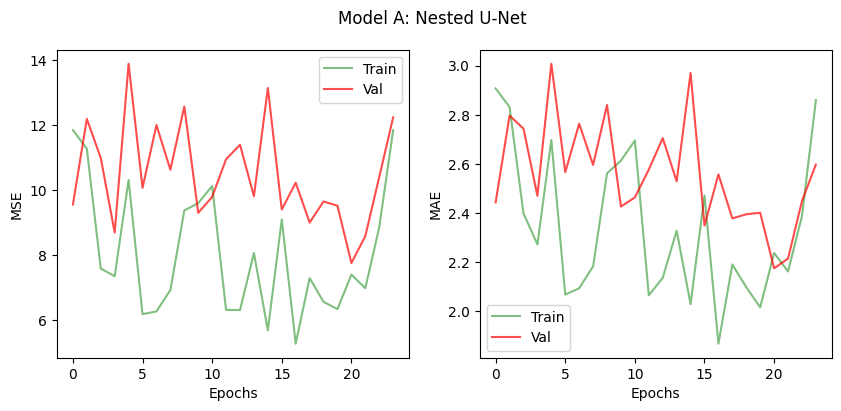

In [ ]:
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(historyA["history"]["loss"], color='g',alpha=.5)
plt.plot(historyA["history"]["val_loss"], color='r',alpha=.7)
plt.legend(["Train","Val"])
plt.ylabel("MSE")
plt.xlabel("Epochs")

plt.subplot(122)
plt.plot(historyA["history"]["mae"], color='g',alpha=.5)
plt.plot(historyA["history"]["val_mae"], color='r',alpha=.7)
plt.legend(["Train","Val"])
plt.ylabel("MAE")
plt.xlabel("Epochs")

plt.suptitle("Model A: Nested U-Net")
plt.show()

In [ ]:
sample = next(train_generator)


In [ ]:
print(modelA(sample[0]))
print(sample[1])

tf.Tensor(
[[[0.65561193 0.05113763 0.13540822 0.15784223]
  [0.65561193 0.05113763 0.13540822 0.15784223]
  [0.65561193 0.05113763 0.13540822 0.15784223]
  ...
  [0.65561193 0.05113763 0.13540822 0.15784223]
  [0.65561193 0.05113763 0.13540822 0.15784223]
  [0.65561193 0.05113763 0.13540822 0.15784223]]

 [[0.71240747 0.05145268 0.12331389 0.112826  ]
  [0.71240747 0.05145268 0.12331389 0.112826  ]
  [0.71240747 0.05145268 0.12331389 0.112826  ]
  ...
  [0.65561193 0.05113763 0.13540822 0.15784223]
  [0.65561193 0.05113763 0.13540822 0.15784223]
  [0.65561193 0.05113763 0.13540822 0.15784223]]

 [[0.65561193 0.05113763 0.13540822 0.15784223]
  [0.65561193 0.05113763 0.13540822 0.15784223]
  [0.65561193 0.05113763 0.13540822 0.15784223]
  ...
  [0.65561193 0.05113763 0.13540822 0.15784223]
  [0.65561193 0.05113763 0.13540822 0.15784223]
  [0.65561193 0.05113763 0.13540822 0.15784223]]

 ...

 [[0.65561193 0.05113763 0.13540822 0.15784223]
  [0.65561193 0.05113763 0.13540822 0.15784223]

In [ ]:
# Validation
val_sample = next(val_generator)
val_result = modelA.predict(val_sample[0])

for x, i in enumerate(val_result):
    RGB = cv2.cvtColor(val_sample[0][x], cv2.COLOR_HSV2RGB)
    MASK = cv2.cvtColor(RGB, cv2.COLOR_RGB2GRAY) > 0
    ARRAY = np.array(val_result[x]).reshape(image_size) * MASK
    OUTPUT = np.array([x for x in ARRAY.flatten() if x > 0])
    print("Validation - Average Output:", np.average(OUTPUT), "Ground Truth:", np.average(val_sample[1][x]))


1/1 [==============================] - 0s 439ms/step


ValueError: cannot reshape array of size 65536 into shape (128,128)

In [110]:
modelC.save('design_models/designA.h5')

In [137]:
# modelA = tf.keras.models.load_model('design_models/designA.h5')

In [218]:
from shutil import rmtree
# removing directory 
rmtree('my_dir') 

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'my_dir'

### Design B

In [23]:
def segnet(hp):
    hp_filters = hp.Choice('filters',values = [16,32,64,128])
    # Encoding layer
    img_input = Input(shape=image_size+(3,))
    x = Conv2D(hp_filters, (3, 3), padding='same', name='conv1',strides= (1,1))(img_input)
    x = BatchNormalization(name='bn1')(x)
    x = Activation('relu')(x)
    x = Conv2D(hp_filters, (3, 3), padding='same', name='conv2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(hp_filters*2 , (3, 3), padding='same', name='conv3')(x)
    x = BatchNormalization(name='bn3')(x)
    x = Activation('relu')(x)
    x = Conv2D(hp_filters*2 , (3, 3), padding='same', name='conv4')(x)
    x = BatchNormalization(name='bn4')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(hp_filters*4, (3, 3), padding='same', name='conv5')(x)
    x = BatchNormalization(name='bn5')(x)
    x = Activation('relu')(x)
    x = Conv2D(hp_filters*4, (3, 3), padding='same', name='conv6')(x)
    x = BatchNormalization(name='bn6')(x)
    x = Activation('relu')(x)
    x = Conv2D(hp_filters*4, (3, 3), padding='same', name='conv7')(x)
    x = BatchNormalization(name='bn7')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(hp_filters*8, (3, 3), padding='same', name='conv8')(x)
    x = BatchNormalization(name='bn8')(x)
    x = Activation('relu')(x)
    x = Conv2D(hp_filters*8, (3, 3), padding='same', name='conv9')(x)
    x = BatchNormalization(name='bn9')(x)
    x = Activation('relu')(x)
    x = Conv2D(hp_filters*8, (3, 3), padding='same', name='conv10')(x)
    x = BatchNormalization(name='bn10')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(hp_filters*8, (3, 3), padding='same', name='conv11')(x)
    x = BatchNormalization(name='bn11')(x)
    x = Activation('relu')(x)
    x = Conv2D(hp_filters*8, (3, 3), padding='same', name='conv12')(x)
    x = BatchNormalization(name='bn12')(x)
    x = Activation('relu')(x)
    x = Conv2D(hp_filters*8, (3, 3), padding='same', name='conv13')(x)
    x = BatchNormalization(name='bn13')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Dense(hp_filters*16, activation = 'relu', name='fc1')(x)
    x = Dense(hp_filters*16, activation = 'relu', name='fc2')(x)
    # Decoding Layer 
    x = UpSampling2D()(x)
    x = Conv2DTranspose(hp_filters*8, (3, 3), padding='same', name='deconv1')(x)
    x = BatchNormalization(name='bn14')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(hp_filters*8, (3, 3), padding='same', name='deconv2')(x)
    x = BatchNormalization(name='bn15')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(hp_filters*8, (3, 3), padding='same', name='deconv3')(x)
    x = BatchNormalization(name='bn16')(x)
    x = Activation('relu')(x)
    
    x = UpSampling2D()(x)
    x = Conv2DTranspose(hp_filters*8, (3, 3), padding='same', name='deconv4')(x)
    x = BatchNormalization(name='bn17')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(hp_filters*8, (3, 3), padding='same', name='deconv5')(x)
    x = BatchNormalization(name='bn18')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(hp_filters*4, (3, 3), padding='same', name='deconv6')(x)
    x = BatchNormalization(name='bn19')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(hp_filters*4, (3, 3), padding='same', name='deconv7')(x)
    x = BatchNormalization(name='bn20')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(hp_filters*4, (3, 3), padding='same', name='deconv8')(x)
    x = BatchNormalization(name='bn21')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(hp_filters*2, (3, 3), padding='same', name='deconv9')(x)
    x = BatchNormalization(name='bn22')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(hp_filters*2, (3, 3), padding='same', name='deconv10')(x)
    x = BatchNormalization(name='bn23')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(hp_filters, (3, 3), padding='same', name='deconv11')(x)
    x = BatchNormalization(name='bn24')(x)
    x = Activation('relu')(x)
    
    x = UpSampling2D()(x)
    x = Conv2DTranspose(hp_filters, (3, 3), padding='same', name='deconv12')(x)
    x = BatchNormalization(name='bn25')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(1, (3, 3), padding='same', name='deconv13')(x)
    x = BatchNormalization(name='bn26')(x)
    output = Activation('softmax')(x)
    # output = Conv2D(1,1)(x)
    # pred = layers.Reshape(image_size)(x)
    # x = Flatten()(x)
    # hp_units = hp.Choice('units',values = [512,1024])
    # x = Dense(hp_units, activation='relu')(x)
    # if hp.Boolean("2nd dense"):
    #     x = Dense(hp_units, activation='relu')(x)
    # if hp.Boolean("3rd dense"):
    #     x = Dense(hp_units, activation='relu')(x)
    # if hp.Boolean("4th dense"):
    #     x = Dense(hp_units, activation='relu')(x)
    # output=Dense(1, activation='softmax')(x)
    
    model = Model(inputs=img_input, outputs=output)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])
    model.compile(optimizer= tf.keras.optimizers.Adam(lr=hp_learning_rate), loss= "mse"
                  , metrics=['mae'])
    return model

In [24]:
tunerB = kt.BayesianOptimization(segnet,
                     objective='val_loss',
                     directory='my_dir',
                     max_trials= 1,
                     project_name='design_b',
                    #  seed=42,
                     )

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


tunerB.search(train_generator, epochs=100, validation_data=val_generator, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hpsB=tunerB.get_best_hyperparameters(num_trials=1)[0]



print(best_hpsB.values)

Reloading Tuner from my_dir\design_b\tuner0.json
{'filters': 128, 'learning_rate': 0.001}


In [25]:
best_hpsB.values['filters']=64

In [26]:
# Build the model with the best hp.
modelB = segnet(best_hpsB)
modelB.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 128, 128, 64)      1792      
                                                                 
 bn1 (BatchNormalization)    (None, 128, 128, 64)      256       
                                                                 
 activation (Activation)     (None, 128, 128, 64)      0         
                                                                 
 conv2 (Conv2D)              (None, 128, 128, 64)      36928     
                                                                 
 bn2 (BatchNormalization)    (None, 128, 128, 64)      256       
                                                                 
 activation_1 (Activation)   (None, 128, 128, 64)      0     

c:\Users\miniconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [27]:
epochs = 512
steps_per_epoch = 512 // batch_size + 1  # we usually consider 1 epoch to be
                                            # the point where the model has seen
                                            # all the training samples at least once
min_lr = 1e-8
factor = 0.1
SCHEDULE_EPOCH = 200
STEPS = 200


historyB = {"history":{"loss":[],"mae":[],"val_loss":[],"val_mae":[]}}
for e in range(epochs):
    for i, (images, y_batch) in enumerate(train_generator):
       new_y_batch = []
       for x,img in enumerate(images):
        array = np.ones(image_size+(3,))
        array *= img>0
        array[array>0] = y_batch[x]
        new_y_batch.append(array)
       new_y_batch = np.array(new_y_batch)
       loss = modelB.train_on_batch(images, new_y_batch)  # train model for a single iteration
    #    val = modelB.test_on_batch(images, new_y_batch)
       if i >= steps_per_epoch:  # manually detect the end of the epoch
            historyB["history"]["loss"].append(loss[0])
            historyB["history"]["mae"].append(loss[1])
            # print("EPOCH: {} LOSS: {:.6f} 2ND_METRIC: {:.6f}".format(e+1, loss[0], loss[1]))
            break  
    for i, (images, y_batch) in enumerate(val_generator):
       new_y_batch = []
       for x,img in enumerate(images):
        array = np.ones(image_size+(3,))
        array *= img>0
        array[array>0] = y_batch[x]
        new_y_batch.append(array)
       new_y_batch = np.array(new_y_batch)
    #    loss = modelB.train_on_batch(images, new_y_batch)  # train model for a single iteration
       val = modelB.test_on_batch(images, new_y_batch)
       if i >= steps_per_epoch:  # manually detect the end of the epoch
            historyB["history"]["val_loss"].append(val[0])
            historyB["history"]["val_mae"].append(val[1])
            # print("EPOCH: {} LOSS: {:.6f} 2ND_METRIC: {:.6f}".format(e+1, loss[0], loss[1]))
            curr_lr = modelB.optimizer.learning_rate
            if e>=SCHEDULE_EPOCH and curr_lr>min_lr: 
               K.set_value(modelB.optimizer.learning_rate, curr_lr*factor)
               curr_lr = modelB.optimizer.learning_rate
               SCHEDULE_EPOCH+=STEPS
            # patience = 2
            # if e>patience and curr_lr>min_lr:
               # curr_loss = historyA["history"]["val_loss"][-1]
               # for i in historyA["history"]["val_loss"][-patience-1:-1]:
               #    if curr_loss >= i: patience-=1
               #    if patience < 1:
                     # K.set_value(modelA.optimizer.learning_rate, curr_lr*factor)
                     # curr_lr = modelA.optimizer.learning_rate
            break  
    print("EPOCH: {} LOSS: {:.6f} MAE: {:.6f} VAL_LOSS: {:.6f} VAL_MAE: {:.6f}   CURR_LR {:.2E}".format(e+1, loss[0], loss[1],val[0],val[1], curr_lr.numpy()))
    train_generator.on_epoch_end()  # this shuffles the data at the end of each epoch

EPOCH: 1 LOSS: 16.031548 MAE: 3.026057 VAL_LOSS: 647260.312500 VAL_MAE: 709.472412   CURR_LR 1.00E-03
EPOCH: 2 LOSS: 17.935232 MAE: 3.274943 VAL_LOSS: 12.609205 VAL_MAE: 3.047642   CURR_LR 1.00E-03
EPOCH: 3 LOSS: 21.029537 MAE: 3.479836 VAL_LOSS: 19.772387 VAL_MAE: 3.749284   CURR_LR 1.00E-03
EPOCH: 4 LOSS: 25.167118 MAE: 4.020483 VAL_LOSS: 27.420738 VAL_MAE: 4.190232   CURR_LR 1.00E-03
EPOCH: 5 LOSS: 17.170757 MAE: 3.186954 VAL_LOSS: 23.730463 VAL_MAE: 3.932538   CURR_LR 1.00E-03
EPOCH: 6 LOSS: 27.875029 MAE: 4.240236 VAL_LOSS: 24.569538 VAL_MAE: 3.989704   CURR_LR 1.00E-03
EPOCH: 7 LOSS: 21.865253 MAE: 3.688179 VAL_LOSS: 21.690712 VAL_MAE: 3.843774   CURR_LR 1.00E-03
EPOCH: 8 LOSS: 20.869724 MAE: 3.597764 VAL_LOSS: 17.408825 VAL_MAE: 3.474829   CURR_LR 1.00E-03
EPOCH: 9 LOSS: 16.997074 MAE: 3.140783 VAL_LOSS: 17.059370 VAL_MAE: 3.564064   CURR_LR 1.00E-03
EPOCH: 10 LOSS: 18.962076 MAE: 3.419259 VAL_LOSS: 18.413883 VAL_MAE: 3.688815   CURR_LR 1.00E-03
EPOCH: 11 LOSS: 16.018703 MAE: 3.

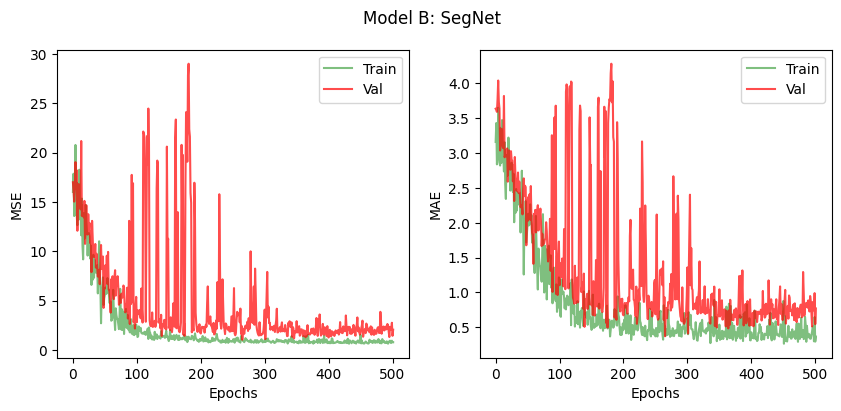

In [28]:
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(historyB["history"]["loss"][10:], color='g',alpha=.5)
plt.plot(historyB["history"]["val_loss"][10:], color='r',alpha=.7)
plt.legend(["Train","Val"])
plt.ylabel("MSE")
plt.xlabel("Epochs")

plt.subplot(122)
plt.plot(historyB["history"]["mae"][10:], color='g',alpha=.5)
plt.plot(historyB["history"]["val_mae"][10:], color='r',alpha=.7)
plt.legend(["Train","Val"])
plt.ylabel("MAE")
plt.xlabel("Epochs")

plt.suptitle("Model B: SegNet")
plt.show()

In [59]:
np.array(historyB["history"]["loss"]).shape

(512,)

In [60]:
# red_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
#                               patience=10, min_lr=1e-7)
# # stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
# history = modelB.fit(train_generator, epochs=2,# validation_data=val_generator,
#                      callbacks=[red_lr])

In [61]:
sample = next(train_generator)


In [62]:
sample = next(train_generator)
result = modelB(sample[0])
for x,i in enumerate(result):
    RGB  = cv2.cvtColor(sample[0][x],cv2.COLOR_HSV2RGB)
    MASK = cv2.cvtColor(RGB, cv2.COLOR_RGB2GRAY) > 0
    ARRAY = np.array(result[5]).reshape(image_size) * MASK
    OUTPUT = np.array([x for x in ARRAY.flatten() if x > 0])
    print(np.average(OUTPUT), np.average(sample[1][x]))

5.1922855 8.0
4.7895346 6.0
5.154698 6.0
5.111763 7.0
4.8827047 8.0
6.373744 8.0
5.8923993 7.0
5.590245 8.0
4.9166474 7.0
4.9280276 8.0
5.2860417 8.0
4.9800115 6.0
4.8004656 7.0
5.2359037 8.0
5.177769 7.0
5.587097 9.0
5.481931 6.0
4.657199 8.0
5.428292 7.0
5.1526184 8.0
5.0169916 8.0
4.7930617 7.0
5.009286 8.0
4.7918706 6.0
4.6733303 9.0
4.820064 9.0
4.8492365 9.0
5.3279824 8.0
5.1716046 6.0
5.2848806 8.0
5.6768694 9.0
5.672272 9.0


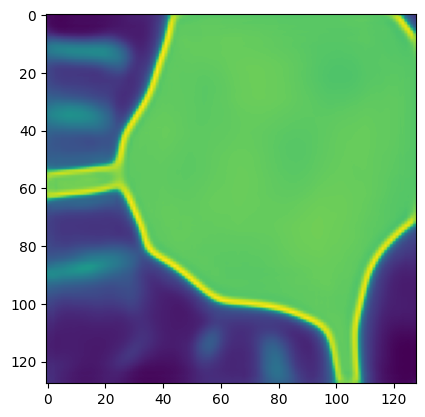

In [63]:

plt.imshow(result[5])

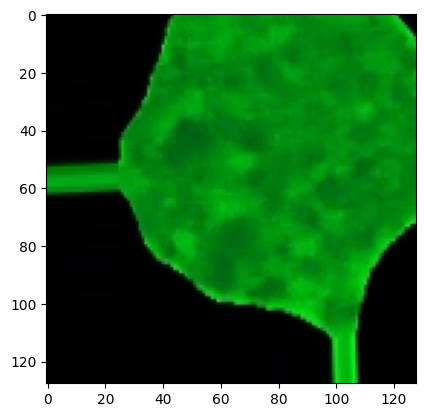

In [64]:
plt.imshow(sample[0][5])

In [65]:
import cv2
RGB  = cv2.cvtColor(sample[0][5],cv2.COLOR_HSV2RGB)
MASK = cv2.cvtColor(RGB, cv2.COLOR_RGB2GRAY) > 0
ARRAY = np.array(result[5]).reshape(image_size) * MASK


In [85]:
AVE = np.average(ARRAY)
TRUTH = sample[1][5]
print(AVE)
print(TRUTH)

1.0256219
9


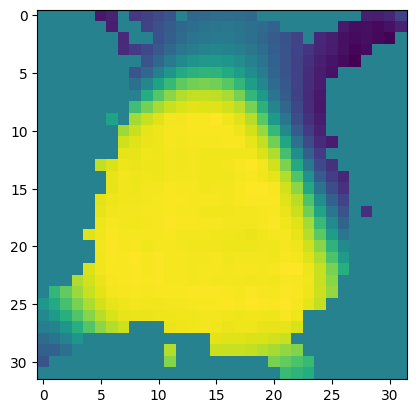

In [80]:
plt.imshow(ARRAY)
plt.show()

In [16]:
modelA.save('design_models/BEST/designA_V3.h5')
modelB.save('design_models/BEST/designB_V3.h5')
modelC.save('design_models/BEST/designC_V3.h5')

In [109]:
from shutil import rmtree
# removing directory 
rmtree('my_dir') 

### Design C

In [8]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input, num_filters):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, num_filters=num_filters, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, num_filters=num_filters,  kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, num_filters=num_filters,  kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, num_filters=num_filters,  kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

def DeeplabV3Plus(hp):
    model_input = keras.Input(shape=image_size+(3,))
    resnet50 = keras.applications.ResNet50(
        weights='imagenet', include_top=False, input_tensor=model_input
    )
    for layer in resnet50.layers:
        layer.trainable=True
    
    hp_filters = hp.Choice('filters',values = [16,32,64,128])
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x, hp_filters*4)
    SIZE=image_size[0]
    input_a = layers.UpSampling2D(
        size=(SIZE // 4 // x.shape[1], SIZE // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=hp_filters, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x, num_filters=hp_filters*4)
    x = convolution_block(x, num_filters=hp_filters*4)
    x = layers.UpSampling2D(
        size=(SIZE // x.shape[1], SIZE // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(1, 1, padding="same", activation='softmax')(x)
    # x = layers.GlobalAveragePooling2D()(x)
    # hp_units = hp.Choice('units',values = [512,1024])
    # x = Dense(hp_units, activation='relu')(x)
    # if hp.Boolean("2nd dense"):
    #     x = Dense(hp_units, activation='relu')(x)
    # model_output = layers.Dense(1, activation='softmax')(x)
    model  = keras.Model(inputs=model_input, outputs=model_output)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])
    model.compile(optimizer=tf.keras.optimizers.Adam(hp_learning_rate), loss='mse', metrics=['mae'])
    return model


# modelC = DeeplabV3Plus(image_size=image_size[0])
# modelC.summary()

In [9]:
tunerC = kt.BayesianOptimization(DeeplabV3Plus,
                     objective='val_loss',
                     directory='my_dir',
                     max_trials= 1,
                     project_name='design_a',
                    #  seed=42,
                     )

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tunerC.search(train_generator, epochs=100, validation_data=val_generator, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hpsC=tunerC.get_best_hyperparameters(num_trials=1)[0]

print(best_hpsC.values)

Reloading Tuner from my_dir\design_a\tuner0.json
{'filters': 16, 'learning_rate': 1e-05}


In [12]:
best_hpsC.values['filters']=64
best_hpsC.values['learning_rate']=1e-6
# Build the model with the best hp.
modelC = DeeplabV3Plus(best_hpsC)
modelC.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']       

In [13]:
epochs = 512
steps_per_epoch = 512 // batch_size + 1  # we usually consider 1 epoch to be
                                            # the point where the model has seen
                                            # all the training samples at least once
min_lr = 1e-8
factor = 0.1
SCHEDULE_EPOCH = 200
STEPS = 200

historyC = {"history":{"loss":[],"mae":[],"val_loss":[],"val_mae":[]}}
for e in range(epochs):
    for i, (images, y_batch) in enumerate(train_generator):
       new_y_batch = []
       for x,img in enumerate(images):
        array = np.ones(image_size+(3,))
        array *= img>0
        array[array>0] = y_batch[x]
        new_y_batch.append(array)
       new_y_batch = np.array(new_y_batch)
       loss = modelC.train_on_batch(images, new_y_batch)  # train model for a single iteration
    #    val = modelB.test_on_batch(images, new_y_batch)
       if i >= steps_per_epoch:  # manually detect the end of the epoch
            historyC["history"]["loss"].append(loss[0])
            historyC["history"]["mae"].append(loss[1])
            # print("EPOCH: {} LOSS: {:.6f} 2ND_METRIC: {:.6f}".format(e+1, loss[0], loss[1]))
            break  
    for i, (images, y_batch) in enumerate(val_generator):
       new_y_batch = []
       for x,img in enumerate(images):
        array = np.ones(image_size+(3,))
        array *= img>0
        array[array>0] = y_batch[x]
        new_y_batch.append(array)
       new_y_batch = np.array(new_y_batch)
    #    loss = modelB.train_on_batch(images, new_y_batch)  # train model for a single iteration
       val = modelC.test_on_batch(images, new_y_batch)
       if i >= steps_per_epoch:  # manually detect the end of the epoch
            historyC["history"]["val_loss"].append(val[0])
            historyC["history"]["val_mae"].append(val[1])
            # print("EPOCH: {} LOSS: {:.6f} 2ND_METRIC: {:.6f}".format(e+1, loss[0], loss[1]))
            curr_lr = modelC.optimizer.learning_rate
            if e>=SCHEDULE_EPOCH and curr_lr>min_lr: 
               K.set_value(modelC.optimizer.learning_rate, curr_lr*factor)
               curr_lr = modelC.optimizer.learning_rate
               SCHEDULE_EPOCH+=STEPS
            # patience = 2
            # if e>patience and curr_lr>min_lr:
               # curr_loss = historyA["history"]["val_loss"][-1]
               # for i in historyA["history"]["val_loss"][-patience-1:-1]:
               #    if curr_loss >= i: patience-=1
               #    if patience < 1:
                     # K.set_value(modelA.optimizer.learning_rate, curr_lr*factor)
                     # curr_lr = modelA.optimizer.learning_rate
            break  
    print("EPOCH: {} LOSS: {:.6f} MAE: {:.6f} VAL_LOSS: {:.6f} VAL_MAE: {:.6f}   CURR_LR {:.2E}".format(e+1, loss[0], loss[1],val[0],val[1], curr_lr.numpy()))
    train_generator.on_epoch_end()  # this shuffles the data at the end of each epoch

EPOCH: 1 LOSS: 17.903214 MAE: 3.259767 VAL_LOSS: 22.247362 VAL_MAE: 3.955492   CURR_LR 1.00E-06
EPOCH: 2 LOSS: 15.741788 MAE: 2.959454 VAL_LOSS: 19.970509 VAL_MAE: 3.671271   CURR_LR 1.00E-06
EPOCH: 3 LOSS: 17.970587 MAE: 3.170188 VAL_LOSS: 21.588490 VAL_MAE: 3.892395   CURR_LR 1.00E-06
EPOCH: 4 LOSS: 17.131773 MAE: 3.067238 VAL_LOSS: 19.689587 VAL_MAE: 3.732247   CURR_LR 1.00E-06
EPOCH: 5 LOSS: 13.855343 MAE: 2.888468 VAL_LOSS: 21.568596 VAL_MAE: 3.954837   CURR_LR 1.00E-06
EPOCH: 6 LOSS: 20.150393 MAE: 3.489870 VAL_LOSS: 16.978148 VAL_MAE: 3.560852   CURR_LR 1.00E-06
EPOCH: 7 LOSS: 19.376144 MAE: 3.472957 VAL_LOSS: 19.534937 VAL_MAE: 3.904091   CURR_LR 1.00E-06
EPOCH: 8 LOSS: 14.312996 MAE: 2.911171 VAL_LOSS: 16.367428 VAL_MAE: 3.562943   CURR_LR 1.00E-06
EPOCH: 9 LOSS: 11.660279 MAE: 2.660912 VAL_LOSS: 18.304096 VAL_MAE: 3.746618   CURR_LR 1.00E-06
EPOCH: 10 LOSS: 16.987164 MAE: 3.267213 VAL_LOSS: 18.745550 VAL_MAE: 3.838058   CURR_LR 1.00E-06
EPOCH: 11 LOSS: 10.763364 MAE: 2.567679

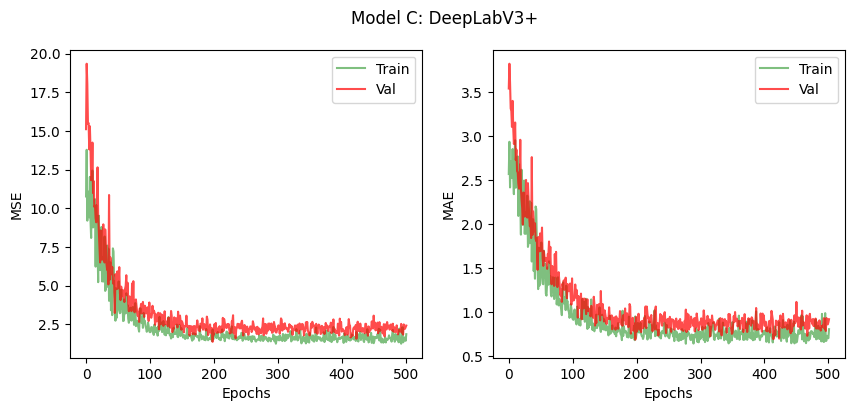

In [14]:
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(historyC["history"]["loss"][10:], color='g',alpha=.5)
plt.plot(historyC["history"]["val_loss"][10:], color='r',alpha=.7)
plt.legend(["Train","Val"])
plt.ylabel("MSE")
plt.xlabel("Epochs")

plt.subplot(122)
plt.plot(historyC["history"]["mae"][10:], color='g',alpha=.5)
plt.plot(historyC["history"]["val_mae"][10:], color='r',alpha=.7)
plt.legend(["Train","Val"])
plt.ylabel("MAE")
plt.xlabel("Epochs")

plt.suptitle("Model C: DeepLabV3+")
plt.show()

In [15]:
sample = next(train_generator)
result = modelC(sample[0])
for x,i in enumerate(result):
    RGB  = cv2.cvtColor(sample[0][x],cv2.COLOR_HSV2RGB)
    MASK = cv2.cvtColor(RGB, cv2.COLOR_RGB2GRAY) > 0
    ARRAY = np.array(result[5]).reshape(image_size) * MASK
    OUTPUT = np.array([x for x in ARRAY.flatten() if x > 0])
    print(np.average(OUTPUT), np.average(sample[1][x]))

7.799823 9.0
6.566419 9.0
7.5840273 9.0
7.461051 8.0
7.625968 7.0
8.188879 9.0
7.2596655 9.0
7.9187207 7.0
8.022246 6.0
7.767962 8.0
7.7645435 7.0
7.787783 7.0
7.502706 7.0
8.216304 8.0
7.0453606 9.0
7.968563 6.0


In [ ]:
# modelC.save('design_models/designC.h5')

In [ ]:
from shutil import rmtree
# removing directory 
rmtree('my_dir') 

## Evaluating Constraints

### MANUFACTURABILITY: TRAINING TIME

In [138]:
epochs = 128
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=4, min_lr=1e-9)
# es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=16, mode="min", restore_best_weights=True)

In [140]:
## DESIGN A
import time 
start = time.time()
historyA = modelA.fit(train_generator, epochs=epochs, validation_data=val_generator, verbose=2, callbacks = [reduce_lr])
stop = time.time()
print(f"Training time: {stop - start}s")

# ## FUNCTIONALITY: INFERENCE TIME
# modelC.evaluate(train_generator[1][0][0].reshape(1,32,32,3))

Epoch 1/128


16/16 - 5s - loss: 99.4323 - mae: 5.0791 - val_loss: 51.0406 - val_mae: 7.0570 - lr: 1.0000e-04 - 5s/epoch - 321ms/step
Epoch 2/128
16/16 - 1s - loss: 2.6698 - mae: 1.3242 - val_loss: 39.7382 - val_mae: 6.2047 - lr: 1.0000e-04 - 1s/epoch - 84ms/step
Epoch 3/128
16/16 - 1s - loss: 1.8973 - mae: 1.1454 - val_loss: 33.6737 - val_mae: 5.6948 - lr: 1.0000e-04 - 1s/epoch - 84ms/step
Epoch 4/128
16/16 - 1s - loss: 1.3084 - mae: 0.9492 - val_loss: 27.3942 - val_mae: 5.1136 - lr: 1.0000e-04 - 1s/epoch - 84ms/step
Epoch 5/128
16/16 - 1s - loss: 1.1753 - mae: 0.9087 - val_loss: 20.7657 - val_mae: 4.4181 - lr: 1.0000e-04 - 1s/epoch - 84ms/step
Epoch 6/128
16/16 - 1s - loss: 1.0557 - mae: 0.8732 - val_loss: 17.1287 - val_mae: 3.9855 - lr: 1.0000e-04 - 1s/epoch - 84ms/step
Epoch 7/128
16/16 - 1s - loss: 1.0540 - mae: 0.8573 - val_loss: 14.8750 - val_mae: 3.6921 - lr: 1.0000e-04 - 1s/epoch - 85ms/step
Epoch 8/128
16/16 - 1s - loss: 1.2161 - mae: 0.9112 - val_loss: 10.1716 - val_mae: 2.9879 - lr: 1.00

In [7]:
## DESIGN B
import time 
start = time.time()
historyB = modelB.fit(train_generator, epochs=epochs, validation_data=val_generator, verbose=2, callbacks = [reduce_lr])
stop = time.time()
print(f"Training time: {stop - start}s")

NameError: name 'modelB' is not defined

In [380]:
## DESIGN C
import time 
start = time.time()
historyC = modelC.fit(train_generator, epochs=epochs, validation_data=val_generator, verbose=2, callbacks = [reduce_lr])
stop = time.time()
print(f"Training time: {stop - start}s")

Epoch 1/128
16/16 - 7s - loss: 52.1323 - mae: 7.1257 - val_loss: 55.8993 - val_mae: 7.3930 - lr: 1.0000e-05 - 7s/epoch - 446ms/step
Epoch 2/128
16/16 - 1s - loss: 40.1086 - mae: 6.2171 - val_loss: 52.3317 - val_mae: 7.1476 - lr: 1.0000e-05 - 935ms/epoch - 58ms/step
Epoch 3/128
16/16 - 1s - loss: 29.2437 - mae: 5.2535 - val_loss: 46.4533 - val_mae: 6.7238 - lr: 1.0000e-05 - 955ms/epoch - 60ms/step
Epoch 4/128
16/16 - 1s - loss: 19.9652 - mae: 4.2573 - val_loss: 37.7043 - val_mae: 6.0384 - lr: 1.0000e-05 - 943ms/epoch - 59ms/step
Epoch 5/128
16/16 - 1s - loss: 12.6390 - mae: 3.3172 - val_loss: 26.9307 - val_mae: 5.0683 - lr: 1.0000e-05 - 957ms/epoch - 60ms/step
Epoch 6/128
16/16 - 1s - loss: 7.0398 - mae: 2.3238 - val_loss: 16.8671 - val_mae: 3.9527 - lr: 1.0000e-05 - 939ms/epoch - 59ms/step
Epoch 7/128
16/16 - 1s - loss: 3.7456 - mae: 1.6009 - val_loss: 10.1775 - val_mae: 2.9894 - lr: 1.0000e-05 - 955ms/epoch - 60ms/step
Epoch 8/128
16/16 - 1s - loss: 2.3669 - mae: 1.2491 - val_loss: 6.

### ECONOMIC: FLOATING-POINT OPERATIONS PER SECOND

In [381]:
## Design A
## ECONOMIC: FLOATING-POINT OPERATIONS PER SECOND
# Calculae FLOPS
from keras_flops import get_flops
flopsA = get_flops(modelA, batch_size=1)
print(f"FLOPS: {flopsA}")

FLOPS: 2054807061


In [382]:
## Design B
## ECONOMIC: FLOATING-POINT OPERATIONS PER SECOND
# Calculae FLOPS
from keras_flops import get_flops
flopsB = get_flops(modelB, batch_size=1)
print(f"FLOPS: {flopsB}")

FLOPS: 1339928587


In [383]:
## Design C
## ECONOMIC: FLOATING-POINT OPERATIONS PER SECOND
# Calculae FLOPS
from keras_flops import get_flops
flopsC = get_flops(modelC, batch_size=1)
print(f"FLOPS: {flopsC}")

FLOPS: 1854608519


### FUNCTIONALITY: INFERENCE TIME

In [384]:
inference_sample = train_generator[1][0][0].reshape(1,32,32,3)

In [418]:
## Design A
## FUNCTIONALITY: INFERENCE TIME
start = time.time()
modelA.predict(inference_sample)
stop = time.time()
print(f"Inference time: {(stop - start)*1e3:.4f}ms")


1/1 [==============================] - 0s 300ms/step
Inference time: 570.9851ms


In [419]:
## Design B
## FUNCTIONALITY: INFERENCE TIME
start = time.time()
modelB.predict(inference_sample)
stop = time.time()
print(f"Inference time: {(stop - start)*1e3:.4f}ms")


1/1 [==============================] - 0s 156ms/step
Inference time: 304.4195ms


In [420]:
## Design AC
## FUNCTIONALITY: INFERENCE TIME
start = time.time()
modelC.predict(inference_sample)
stop = time.time()
print(f"Inference time: {(stop - start)*1e3:.4f}ms")


1/1 [==============================] - 0s 45ms/step
Inference time: 102.9987ms


### PERFORMANCE: COEFFICIENT OF DETERMINATION

In [421]:
## Prepare set of x values and y values for performance constraint
X_values,y_values = [],[]
for i in range(100):
    values = next(train_generator)
    # for j in range(values[0].shape[0]):
    X_values.append(values[0])
    y_values.append(values[1])

## create X_values generator
gen_X_values_1 = (x for x in X_values)
gen_X_values_2 = (x for x in X_values)
gen_X_values_3 = (x for x in X_values)
y_values = [y  for y_set in y_values for y in y_set]

In [422]:
## Design A
## PERFORMANCE: COEFFICIENT OF DETERMINATION
from sklearn.metrics import r2_score
predictionsA = modelA.predict(gen_X_values_1).reshape(3200)
codA = r2_score(y_values,predictionsA)
print(f'{codA:.4f}')

100/100 [==============================] - 2s 23ms/step
0.5706


In [423]:
## Design B
## PERFORMANCE: COEFFICIENT OF DETERMINATION
from sklearn.metrics import r2_score
predictionsB = modelB.predict(gen_X_values_2).reshape(3200)
codB = r2_score(y_values,predictionsB)
print(f'{codB:.4f}')

100/100 [==============================] - 2s 16ms/step
0.4405


In [424]:
## Design B
## PERFORMANCE: COEFFICIENT OF DETERMINATION
from sklearn.metrics import r2_score
predictionsC = modelC.predict(gen_X_values_3).reshape(3200)
codC = r2_score(y_values,predictionsC)
print(f'{codC:.4f}')

100/100 [==============================] - 2s 18ms/step
0.0367


### EFFICIENCY: STORAGE CONSUMPTION

In [415]:
## EFFICIENCY: STORAGE CONSUMPTION
weightsA = modelA.get_weights()
total_sizeA = 0
for weight in weightsA:
    total_sizeA += tf.size(weight).numpy()

print(f"Total model weight size in megabytes: {total_sizeA*8e-6:.4f}")

Total model weight size in megabytes: 669.7216


In [416]:
## EFFICIENCY: STORAGE CONSUMPTION
weightsB = modelB.get_weights()
total_sizeB = 0
for weight in weightsB:
    total_sizeB += tf.size(weight).numpy()

print(f"Total model weight size in megabytes: {total_sizeB*8e-6:.4f}")

Total model weight size in megabytes: 535.5884


In [417]:
total_sizeB/(8e6)

8.368568125

In [394]:
## EFFICIENCY: STORAGE CONSUMPTION
weightsC = modelC.get_weights()
total_sizeC = 0
for weight in weightsC:
    total_sizeC += tf.size(weight).numpy()

print(f"Total model weight size in megabytes: {total_sizeC*8e-6:.4f}")

Total model weight size in megabytes: 147.002376


## Saving final trained and constrained models

In [395]:
modelA.save('design_models/designA_v2.h5')
modelB.save('design_models/designB_v2.h5')
modelC.save('design_models/designC_v2.h5')